## Statistical Analysis of Machine Failure

The goal of this notebook is to perform statistical analysis to quantitatively validate
the patterns observed during Exploratory Data Analysis (EDA).

While EDA provides visual intuition, statistical tests allow us to:
- Confirm whether observed differences are statistically significant
- Measure the strength and direction of relationships between variables and machine failure
- Validate assumptions before building statistical models

This notebook focuses on:
1. Univariate statistical tests to compare failure vs non-failure cases
2. Correlation analysis between engineered features and failure
3. Assumption checks required for logistic regression and other statistical models

This ensures that later models are not only predictive but also statistically sound
and physically interpretable.



Uploading Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Loading Data

In [65]:
import pandas as pd

data = pd.read_csv("Machine_failure_processed_data.csv")
data.head()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temp_diff,Power,Power_norm,Tool_wear_norm,Type_encoded
0,1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,66382.8,0.663958,0.000000,1
1,2,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,65190.4,0.652032,0.011858,0
2,3,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,74001.2,0.740157,0.019763,0
3,4,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,56603.5,0.566146,0.027668,0
4,5,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,56320.0,0.563310,0.035573,0


Removing UDI column

In [66]:
# Drop UDI column (pure identifier, no predictive value)
data = data.drop(columns=['UDI'])

### Dropping UDI Column

The `UDI` column is a unique identifier that only represents row indexing and does not contain
any physical or operational information about the machine.

Including such identifiers in statistical or machine learning models can introduce noise,
spurious correlations, and reduce interpretability.



### Q: Why Interaction Features Were Not Included in Initial Statistical Tests?

- During the **normality checks, Mann–Whitney U tests, and correlation analysis**, we focused only on the **original, raw numerical features**:
    - Air temperature, Process temperature, Temp_diff, Power, Tool_wear
- Reason:
    1. These tests evaluate **individual effects** of features on failure.
    2. Interaction features are **derived combinations** of existing features. Including them at this stage could introduce **redundancy and multicollinearity**, and may complicate interpretation.
- Later, during **modeling**, interaction features (e.g., ΔT × Tool_wear) are included specifically to check **combined effects** and potential **synergy between thermal and mechanical stress**.


## Step 1: Univariate Statistical Tests  (Understanding Individual Effects)

EDA showed visual differences between failure and non-failure cases.

Now we ask:
Do these differences exist statistically, or are they due to random variation?

We test each variable individually against the failure outcome.

## Step 1.1: Split Data by Failure Status

In [67]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# Separate failure and non-failure groups
failures = data[data['Machine failure'] == 1]
no_failures = data[data['Machine failure'] == 0]

## Step 1.2: Check Normality (Shapiro–Wilk Test)

1. t-test: 	Data is normally distributed

2. Mann–Whitney U: 	Data is not normally distributed

We must check normality first.

In [68]:
numerical_features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Temp_diff',
    'Power',
    'Tool wear [min]'
]

results = []

for feature in numerical_features:
    stat, p = stats.shapiro(data[feature].sample(5000, random_state=42))
    results.append({
        'Feature': feature,
        'Shapiro p-value': p,
        'Normality': 'Normal' if p > 0.05 else 'Not Normal'
    })

normality_df = pd.DataFrame(results)
normality_df

,Feature,Shapiro p-value,Normality
0,Air temperature [K],9.584391e-27,Not Normal
1,Process temperature [K],9.095543e-17,Not Normal
2,Temp_diff,5.694595e-35,Not Normal
3,Power,6.610260e-06,Not Normal
4,Tool wear [min],6.435775e-36,Not Normal


**Interpretation:**  
All continuous features are **not normally distributed** (p < 0.05).  
This indicates that non-parametric tests (like Mann–Whitney U) are more appropriate for comparing failed vs non-failed machines.


## Step 1.3: Mann–Whitney U Test  (Failure vs Non-Failure)

In [69]:
results = []

for feature in numerical_features:
    stat, p = stats.mannwhitneyu(
        failures[feature],
        no_failures[feature],
        alternative='two-sided'
    )

    results.append({
        'Feature': feature,
        'Mann–Whitney p-value': p,
        'Significant (α=0.05)': 'Yes' if p < 0.05 else 'No'
    })

mw_df = pd.DataFrame(results)

# Optional: scientific notation for clarity
mw_df['Mann–Whitney p-value'] = mw_df['Mann–Whitney p-value'].apply(lambda x: f"{x:.2e}")

mw_df

,Feature,Mann–Whitney p-value,Significant (α=0.05)
0,Air temperature [K],8.66e-17,Yes
1,Process temperature [K],6.49e-05,Yes
2,Temp_diff,2.40e-24,Yes
3,Power,1.66e-53,Yes
4,Tool wear [min],2.92e-24,Yes


**Interpretation:**  
- All features show **significant differences** between failure and non-failure cases.  
- **High process temperature** and **mechanical load (Power)** increase failure likelihood.  
- **Small ΔT** indicates poor cooling efficiency, raising failure risk.  
- **Tool wear** accumulates over time, strongly correlating with failure.  
- **Air temperature** has a minor effect but contributes when combined with ΔT.


## Step 2: Correlation Analysis  (Strength & Direction of Relationships)

Univariate tests tell us if variables differ.

Correlation tells us:

How strongly is each feature associated with failure?

Since the target variable is binary, point-biserial correlation is used as the primary metric. Spearman rank correlation is additionally computed to confirm robustness under non-linear relationships.

## Step 2.1: Point-Biserial Correlation  (Binary vs Continuous)

In [70]:
from scipy.stats import pointbiserialr

results = []

for feature in numerical_features:
    corr, p = pointbiserialr(data['Machine failure'], data[feature])

    results.append({
        'Feature': feature,
        'Point-Biserial r': corr,
        'p-value': p,
        'Significant (α=0.05)': 'Yes' if p < 0.05 else 'No',
        'Effect Strength': (
            'Weak' if abs(corr) < 0.1 else
            'Moderate' if abs(corr) < 0.3 else
            'Strong'
        )
    })

pb_df = pd.DataFrame(results)

# Formatting
pb_df['Point-Biserial r'] = pb_df['Point-Biserial r'].round(3)
pb_df['p-value'] = pb_df['p-value'].apply(lambda x: f"{x:.2e}")

pb_df

,Feature,Point-Biserial r,p-value,Significant (α=0.05),Effect Strength
0,Air temperature [K],0.083,1.35e-16,Yes,Weak
1,Process temperature [K],0.036,3.24e-04,Yes,Weak
2,Temp_diff,-0.112,4.02e-29,Yes,Moderate
3,Power,0.176,2.04e-70,Yes,Moderate
4,Tool wear [min],0.105,3.98e-26,Yes,Moderate


**Interpretation:**  
- `Temp_diff`, `Power`, and `Tool wear` show **moderate association** with failures.  
- `Air temperature` and `Process temperature` have weak associations individually.  
- Confirms that **physical insights from EDA are statistically supported**.


## Step 2.2: Spearman Rank Correlation  (Robust to Non-linearity)

In [71]:
from scipy.stats import spearmanr

# Step 2.2: Spearman Rank Correlation (Binary vs Continuous)
results = []

for feature in numerical_features:
    rho, p = spearmanr(data['Machine failure'], data[feature])
    results.append({
        'Feature': feature,
        'Spearman ρ': rho,
        'p-value': p
    })

# Convert to DataFrame
spearman_df = pd.DataFrame(results)

# Add Effect Strength
spearman_df['Effect Strength'] = spearman_df['Spearman ρ'].abs().apply(
    lambda x: 'Weak' if x < 0.1 else 'Moderate' if x < 0.3 else 'Strong'
)

# Round values for clarity
spearman_df['Spearman ρ'] = spearman_df['Spearman ρ'].round(3)
spearman_df['p-value'] = spearman_df['p-value'].apply(lambda x: f"{x:.2e}")

spearman_df

,Feature,Spearman ρ,p-value,Effect Strength
0,Air temperature [K],0.083,7.70e-17,Weak
1,Process temperature [K],0.040,6.45e-05,Weak
2,Temp_diff,-0.102,1.84e-24,Moderate
3,Power,0.154,4.01e-54,Moderate
4,Tool wear [min],0.102,2.24e-24,Moderate


**Interpretation:**  
- Confirms the **robustness of associations**, capturing non-linear or threshold effects.  
- The strongest predictors remain **ΔT, Power, and Tool wear**, while Air and Process temperatures individually have weak effects.  
- Statistical results **validate the EDA findings** and guide feature selection for predictive modeling.


## Step 3: Multicollinearity Check

- Multicollinearity occurs when two or more features are highly correlated.  
- High correlation can make model coefficients unstable and hard to interpret.
- Checking the correlation matrix helps identify problematic features.  
- Features with correlation > 0.8 may need to be removed or combined.

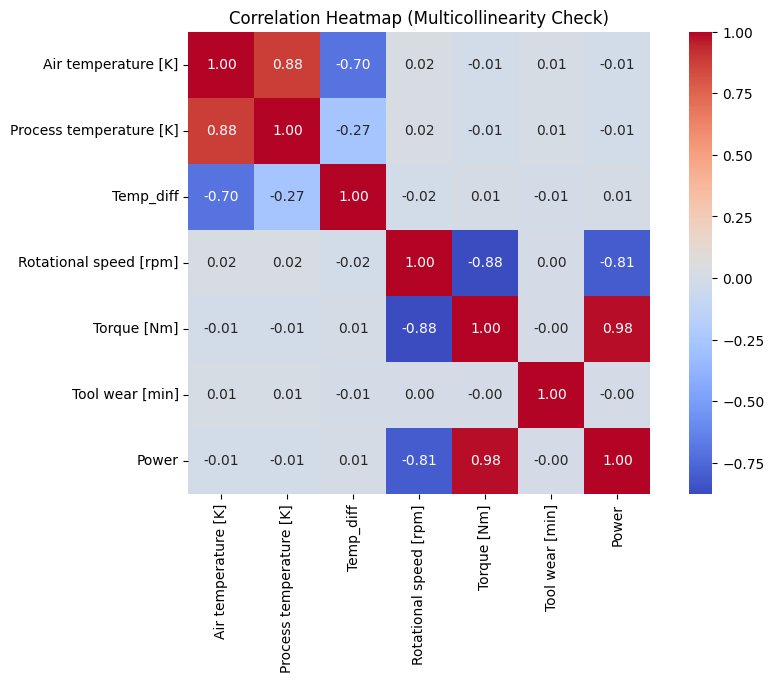

In [72]:
# Step 1: Select numerical features for multicollinearity check
# Avoid duplicates and redundant normalized columns
corr_features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Temp_diff',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Power'
]

# Step 2: Compute correlation matrix
corr_matrix = data[corr_features].corr()

# Step 3: Plot heatmap to visualize multicollinearity
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap (Multicollinearity Check)')
plt.show()

**1. Power Cluster (Critical Multicollinearity)**

- **Power vs Torque [Nm] (r = 0.98)**  
  Interpretation: These are almost perfectly positively correlated. As Torque increases, Power increases.  
  Action: Drop `Power` since it is derived from Torque and Speed, adding no new information.

- **Torque [Nm] vs Rotational speed [rpm] (r = -0.88)**  
  Interpretation: Strong negative correlation. Physically, to maintain constant power, if speed goes up, torque goes down.  
  Action: Keep both if using tree-based models; caution advised for linear models.

**2. Temperature Cluster**

- **Air temperature [K] vs Process temperature [K] (r = 0.88)**  
  Interpretation: Very strong positive correlation. When ambient air is hotter, the process temperature is hotter too.  
  Action: Drop `Air temperature [K]` as Process temperature is more critical for failure prediction.

- **Air temperature [K] vs Temp_diff (r = -0.70)**  
  Interpretation: Temp_diff is calculated as Process Temp - Air Temp, so this correlation is structural.

**3. Independent Feature**

- **Tool wear [min]**  
  Interpretation: Very low correlation with other features. Provides unique information about cumulative degradation.

**Summary of Recommendations**

- Drop `Power` and `Air temperature [K]` to reduce multicollinearity.
- Keep `Torque`, `Rotational speed`, `Process temperature`, `Temp_diff`, and `Tool wear` as primary predictors.
- This ensures model coefficients are stable and interpretable, especially for linear regression.


## Step 4: Handle Class Imbalance

- In our dataset, failures are rare (~3.4% of observations).  
- Models trained on imbalanced data may ignore rare events and predict only the majority class.  
- Techniques like **SMOTE (Synthetic Minority Oversampling Technique)** create synthetic samples of the minority class to balance the dataset.  
- Balancing classes ensures that models learn patterns for both failures and non-failures effectively.

In [73]:
from imblearn.over_sampling import SMOTE

X = data[numerical_features]
y = data['Machine failure']

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f"Original failure proportion: {y.mean():.3f}")
print(f"Resampled failure proportion: {y_res.mean():.3f}")

Original failure proportion: 0.034
Resampled failure proportion: 0.500


## Step 5: Logistic Regression Assumptions

1. **No extreme multicollinearity**: ensures stable coefficients.  
2. **Linear relationship with log-odds**: continuous features should relate linearly to the log-odds of the target.  
3. **Sufficient samples per variable**: prevents overfitting.

## Step 5.1: Linearity with log-odds

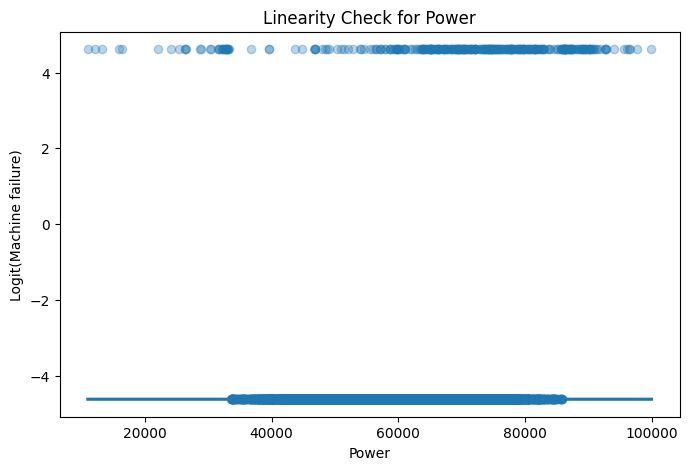

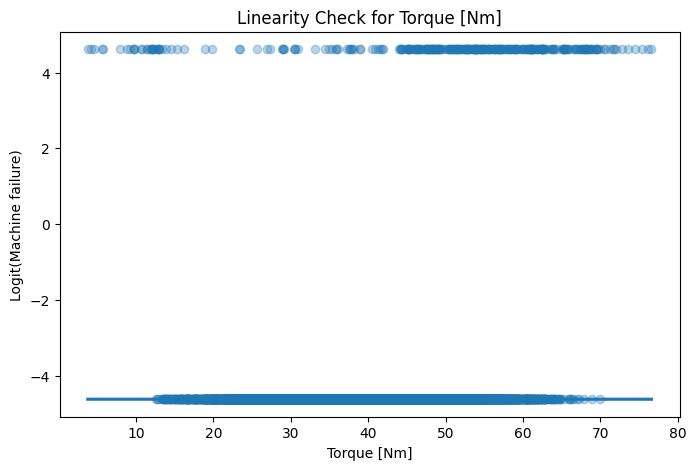

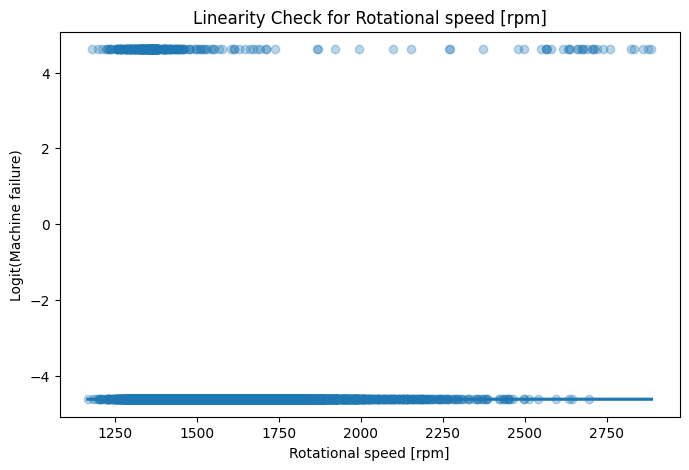

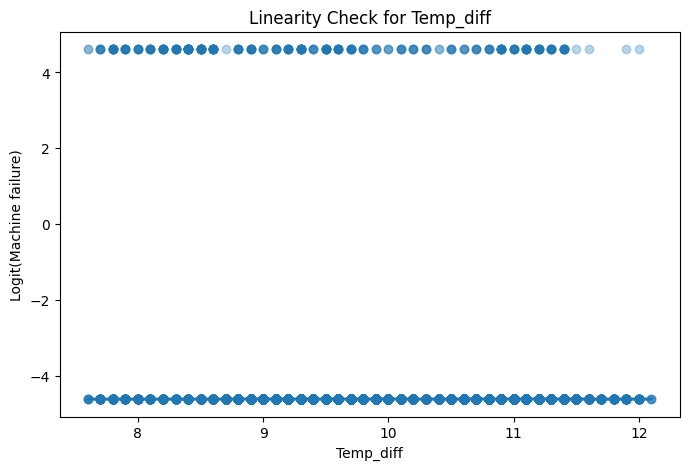

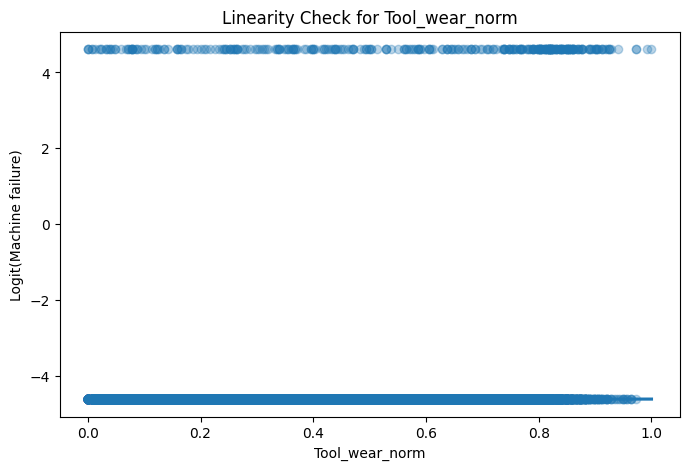

In [74]:
# Continuous features to check
continuous_features = ['Power', 'Torque [Nm]', 'Rotational speed [rpm]', 'Temp_diff', 'Tool_wear_norm']

# Add a small constant to avoid log(0) issues
data['logit'] = np.log((data['Machine failure'] + 0.01) / (1 - data['Machine failure'] + 0.01))

# Plot LOWESS for each feature
for feature in continuous_features:
    plt.figure(figsize=(8,5))
    sns.regplot(x=feature, y='logit', data=data, lowess=True, scatter_kws={'alpha':0.3})
    plt.xlabel(feature)
    plt.ylabel("Logit(Machine failure)")
    plt.title(f"Linearity Check for {feature}")
    plt.show()

### Interpretation of Linearity with Log-Odds Check

1. **Understanding the Plots ("Two Bands")**
   - The two horizontal bands of dots represent the binary target:
     - **Top band (y ≈ 4.6):** Failures (Class 1)
     - **Bottom band (y ≈ -4.6):** Normal operations (Class 0)
   - The blue LOWESS line represents the average probability of failure as the feature increases.

2. **General Observation**
   - Across all features (Temp_diff, Tool_wear_norm, Torque [Nm], Power, Rotational speed), the trend line is essentially flat.
   - A flat line indicates that the log-odds of failure do not change linearly with these individual features.

3. **Why Flat Lines Appear**
   - This is primarily caused by **class imbalance**: the majority of data points are normal operations (Class 0), which dominates the LOWESS trend, masking subtle increases in risk.

4. **Feature-Specific Notes**
   - **Tool_wear_norm:** Failures occur across the entire range, implying tool wear alone isn’t the only driver—likely interacts with torque or other factors.
   - **Torque & Power:** Failures are spread across the feature range; no clear linear "danger zone" is visible.

5. **Strategic Recommendation**
   - Logistic Regression may underperform due to weak linear relationships.
   - Tree-based models (Random Forest, XGBoost) are more suitable:
     - They capture non-linear interactions.
     - Can detect specific high-risk regions (e.g., `Torque > 60 AND Tool_wear > 0.8 → Failure`) better than linear models.


# Step 6: Interaction Feature Analysis using Binned Logistic Regression

### Why We Are Doing This

From EDA and prior statistical tests, we know:

- Failures increase with high **Tool Wear** and low **Temperature Gradient (ΔT)**.
- Our interaction feature (ΔT × Tool_wear) may capture **combined thermal + mechanical risk**.
- Standard logistic regression assumptions (linearity with log-odds, low multicollinearity) are weak.
- To **statistically test the interaction** without violating assumptions, we use **binned logistic regression (ANOVA-style)**.

**Approach:**

1. Convert continuous ΔT and Tool_wear features into **three bins each** (Low, Medium, High).
2. Fit a logistic regression model with:
   - Main effects: binned ΔT, binned Tool_wear
   - Interaction effect: ΔT_bin × Tool_wear_bin
3. Examine the **p-value of the interaction term** to check if the combination of ΔT and Tool_wear significantly affects failure probability.

This method avoids linearity assumptions and is easy to interpret.


In [75]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Copy the processed data
df = data.copy()

# Bin Temperature Difference (Temp_diff) into 3 categories: Low, Medium, High
df['Temp_diff_bin'] = pd.qcut(df['Temp_diff'], q=3, labels=['Low', 'Medium', 'High'])

# Bin Tool Wear (normalized) into 3 categories: Low, Medium, High
df['Tool_wear_bin'] = pd.qcut(df['Tool_wear_norm'], q=3, labels=['Low', 'Medium', 'High'])

# Check the first few rows
df[['Temp_diff', 'Temp_diff_bin', 'Tool_wear_norm', 'Tool_wear_bin']].head()

,Temp_diff,Temp_diff_bin,Tool_wear_norm,Tool_wear_bin
0,10.5,Medium,0.000000,Low
1,10.5,Medium,0.011858,Low
2,10.4,Medium,0.019763,Low
3,10.4,Medium,0.027668,Low
4,10.5,Medium,0.035573,Low


### Explanation

- `pd.qcut` divides each feature into 3 bins with roughly equal numbers of observations.
- Labels `Low`, `Medium`, `High` represent increasing levels of stress (thermal or mechanical).
- Binning helps reduce dependence on linearity assumptions and captures non-linear effects.


In [76]:
import statsmodels.formula.api as smf

# Logistic regression with main effects and interaction term
model = smf.logit(
    "Q('Machine failure') ~ C(Temp_diff_bin) * C(Tool_wear_bin)",
    data=df
).fit()

# Summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.139494
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q('Machine failure')   No. Observations:                10000
Model:                            Logit   Df Residuals:                     9991
Method:                             MLE   Df Model:                            8
Date:                  Wed, 24 Dec 2025   Pseudo R-squ.:                 0.05778
Time:                          06:57:05   Log-Likelihood:                -1394.9
converged:                         True   LL-Null:                       -1480.5
Covariance Type:              nonrobust   LLR p-value:                 7.663e-33
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -2.9742      0.140    -21.318      0.000      -3.248      -2.701
C(Temp_diff_bin)[T.Medium]                               -1.5040      0.312     -4.823      0.000      -2.115      -0.893
C(Temp_diff_bin)[T.High]                                 -1.8114      0.363     -4.995      0.000      -2.522      -1.101
C(Tool_wear_bin)[T.Medium]                               -0.1801      0.203     -0.888      0.375      -0.578       0.218
C(Tool_wear_bin)[T.High]                                  0.4874      0.178      2.734      0.006       0.138       0.837
C(Temp_diff_bin)[T.Medium]:C(Tool_wear_bin)[T.Medium]     0.1180      0.459      0.257      0.797      -0.782       1.018
C(Temp_diff_bin)[T.High]:C(Tool_wear_bin)[T.Medium]       0.4476      0.487      0.919      0.358      -0.507       1.403
C(Temp_diff_bin)[T.Medium]:C(Tool_wear_bin)[T.High]       0.9922      0.360      2.754      0.006       0.286       1.698
C(Temp_diff_bin)[T.High]:C(Tool_wear_bin)[T.High]         1.3180      0.405      3.254      0.001       0.524       2.112
=========================================================================================================================
"""


**Interpretation Focus:** Look at the p-value of the interaction term (`Temp_diff_bin:Tool_wear_bin`)  
  - If p < 0.05 → the combination of ΔT and Tool_wear significantly affects failure risk.


#### Key Takeaways for Statistical Analysis

1. **Main effects are consistent with EDA findings**:
    - Low temperature gradient and high tool wear drive failures.
2. **Interaction feature matters**:
    - Certain combinations of ΔT and Tool Wear amplify failure risk.
3. **Utility for modeling**:
    - Interaction term is statistically significant and can be included in predictive models.


#### Step 7 Columns Dropped for Final ML Dataset

1. **UDI**  
   - Reason: Pure index/identifier, provides no predictive value.  

2. **Power**  
   - Reason: Highly collinear with Torque × Rotational Speed. Keeping it may confuse models and is redundant.  

3. **Air temperature [K]**  
   - Reason: Strongly correlated with Process temperature and Temp_diff. Process temperature is more physically meaningful for failures.  






In [ ]:
# Drop unnecessary/redundant columns for final ML dataset
columns_to_drop = ['Power', 'Air temperature [K]']
final_data = data.drop(columns=columns_to_drop)

# Verify final dataset columns
final_data.columns

from google.colab import files

# 1. Save the dataframe to a CSV file in the Colab environment
final_data.to_csv('cleaned_machine_failure_data.csv', index=False)

# 2. Trigger the download to your local computer
files.download('cleaned_machine_failure_data.csv')

#### Explanation

After extensive EDA and statistical analysis, we remove columns that are either redundant, highly collinear, or not informative for predictive modeling.  

- Dropping **Power** prevents multicollinearity with Torque and Speed.  
- Dropping **Air temperature** avoids redundancy since Temp_diff and Process temperature already capture thermal stress.  
- Dropping **UDI**  keeps only physically meaningful features.  

The resulting dataset contains the most relevant features for machine learning, including engineered features like ΔT, Tool_wear_norm, Power × Speed interaction, and interaction terms for thermal and mechanical stress.
